## IMPORT NECESSARY MODULES

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
np.random.seed(0)
plt.style.use('ggplot')
%matplotlib inline
import tensorflow as tf
print('Tensorflow version :',tf.__version__)
print(tf.config.list_physical_devices('GPU'))

Tensorflow version : 2.2.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## LOAD AND EXPLORE THE NER DATASET

In [2]:
data = pd.read_csv('ner_dataset.csv',encoding='latin1')
data = data.fillna(method='ffill')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [3]:
print('Unique words in corpus/data = ',data['Word'].nunique())
print('Unique tags in corpus/data = ',data['Tag'].nunique())

Unique words in corpus/data =  35178
Unique tags in corpus/data =  17


In [4]:
words = list(set(data['Word'].values))
words.append('ENDPAD')
num_words = len(words)
num_words

35179

In [5]:
tags = list(set(data['Tag'].values))
# tags.append('ENDPAD')
num_tags = len(tags)
num_tags

17

In [6]:
num_words,num_tags

(35179, 17)

## RETRIEVING SENTENCES AND THEIR TAGS

In [7]:
class get_sentence(object):
    def __init__(self,data) :
        self.n_sent = 1
        self.data = data
        agg_function = lambda x : [(w,p,t) for w,p,t in zip(x['Word'].values.tolist(),x['POS'].values.tolist(),x['Tag'].values.tolist())]
        
        self.grouped = self.data.groupby('Sentence #').apply(agg_function)
        self.sentences = [s for s in self.grouped]

In [8]:
getter = get_sentence(data)
sentences = getter.sentences

In [9]:
sentences[15]

[('Israeli', 'JJ', 'B-gpe'),
 ('officials', 'NNS', 'O'),
 ('say', 'VBP', 'O'),
 ('Prime', 'NNP', 'B-per'),
 ('Minister', 'NNP', 'I-per'),
 ('Ariel', 'NNP', 'I-per'),
 ('Sharon', 'NNP', 'I-per'),
 ('will', 'MD', 'O'),
 ('undergo', 'VB', 'O'),
 ('a', 'DT', 'O'),
 ('medical', 'JJ', 'O'),
 ('procedure', 'NN', 'O'),
 ('Thursday', 'NNP', 'B-tim'),
 ('to', 'TO', 'O'),
 ('close', 'VB', 'O'),
 ('a', 'DT', 'O'),
 ('tiny', 'JJ', 'O'),
 ('hole', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('his', 'PRP$', 'O'),
 ('heart', 'NN', 'O'),
 ('discovered', 'VBN', 'O'),
 ('during', 'IN', 'O'),
 ('treatment', 'NN', 'O'),
 ('for', 'IN', 'O'),
 ('a', 'DT', 'O'),
 ('minor', 'JJ', 'O'),
 ('stroke', 'NN', 'O'),
 ('suffered', 'VBN', 'O'),
 ('last', 'JJ', 'O'),
 ('month', 'NN', 'O'),
 ('.', '.', 'O')]

## DEFINE MAPPING BETWEEN SENTENCES AND TAGS

In [10]:
word2idx = {w : i+1 for i,w in enumerate(words)}
tag2idx = {t : i for i,t in enumerate(tags)}

In [11]:
# word2idx

## PADDING INPUT SENTENCES AND CREATING TEST/TRAIN SPLITS

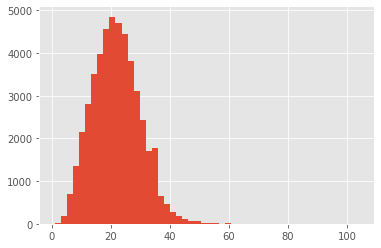

In [12]:
plt.hist([len(s) for s in sentences],bins=50)
plt.show()

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_length = 50

X = [[word2idx[word[0]] for word in s] for s in sentences]
X = pad_sequences(maxlen=max_length,sequences=X,padding='post',value=num_words-1)

y = [[tag2idx[tag[2]] for tag in s] for s in sentences]
y = pad_sequences(maxlen=max_length,sequences=y,padding='post',value=tag2idx['O'])


In [14]:
y = [to_categorical(i,num_classes=num_tags) for i in y]

In [15]:
from sklearn.model_selection import train_test_split


In [28]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=1)
print(X_train.shape)

(43163, 50)


## BUILDING AND COMPILING A BIDIRECTIONAL LSTM MODEL



In [17]:
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed,SpatialDropout1D,Bidirectional

In [18]:
input_word = Input(shape=(max_length,))
model = Embedding(input_dim = num_words,output_dim=max_length,input_length = max_length)(input_word)

model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(model)

In [19]:
out = TimeDistributed(Dense(num_tags,activation='softmax'))(model)

In [20]:
model = Model(input_word,out)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

## TRAIN THE MODEL

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [30]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=1,verbose=0,mode='max',restore_best_weights=False)
callbacks = [PlotLossesCallback(),early_stopping]



In [32]:
history = model.fit(X_train,np.array(y_train),validation_split=0.2,batch_size=32,epochs=3,verbose=1,callbacks=callbacks)

Epoch 1/3
1080/1080 [==============================] - 168s 156ms/step - loss: 0.0602 - accuracy: 0.9827 - val_loss: 0.0519 - val_accuracy: 0.9844
Epoch 2/3
1080/1080 [==============================] - 167s 155ms/step - loss: 0.0403 - accuracy: 0.9879 - val_loss: 0.0488 - val_accuracy: 0.9853
Epoch 3/3
1080/1080 [==============================] - 167s 154ms/step - loss: 0.0326 - accuracy: 0.9898 - val_loss: 0.0478 - val_accuracy: 0.9855


In [34]:
model.evaluate(X_test,np.array(y_test))

150/150 [==============================] - 3s 18ms/step - loss: 0.0487 - accuracy: 0.9854


[0.04865507036447525, 0.9853670001029968]

In [88]:
i = np.random.randint(0,X_test.shape[0])
# print(len(i))
p = model.predict(np.array(X_test[i]))
p = np.argmax(p,axis=-1)
y_true = np.argmax(np.array(y_test),axis=-1)[i]
                   
print('{:15}{:5}\t {}\n'.format('Word','True','Predicted Values'))
print('-'*41)
for w,true,predicted in zip(X_test[i],y_true,p):
#     print(w)
    print('{:15}{:5}\t {}\n'.format(words[w-1],tags[true],tags[predicted[0]]))

Word           True 	 Predicted Values

-----------------------------------------
South          O    	 I-geo

Korean         B-gpe	 B-gpe

officials      O    	 O

have           O    	 O

not            O    	 O

confirmed      O    	 O

the            O    	 O

report         O    	 O

.              O    	 O

purchase       O    	 O

purchase       O    	 O

purchase       O    	 O

purchase       O    	 O

purchase       O    	 O

purchase       O    	 O

purchase       O    	 O

purchase       O    	 O

purchase       O    	 O

purchase       O    	 O

purchase       O    	 O

purchase       O    	 O

purchase       O    	 O

purchase       O    	 O

purchase       O    	 O

purchase       O    	 O

purchase       O    	 O

purchase       O    	 O

purchase       O    	 O

purchase       O    	 O

purchase       O    	 O

purchase       O    	 O

purchase       O    	 O

purchase       O    	 O

purchase       O    	 O

purchase       O    	 O

purchase       O    	 O

purchase  